## 1. Setup

In [67]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Đồ án Python/coffee_project"


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Setup complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Đồ án Python/coffee_project
✅ Setup complete!


## 2. Load Data

In [68]:
# Load clustered data (có cột 'cluster')
df = pd.read_csv("results/kmeans_best_labels.csv")

print(f"Data shape: {df.shape}")
print(f"Cluster column: {'cluster' in df.columns}")

# Tách features và labels
if 'cluster' in df.columns:
    X = df.drop('cluster', axis=1)
    labels = df['cluster']
    print(f"Clusters found: {sorted(labels.unique())}")
    print(f"Cluster distribution:\n{labels.value_counts().sort_index()}")
else:
    print("⚠️ No 'cluster' column found!")

Data shape: (3685, 59)
Cluster column: True
Clusters found: [np.int64(0), np.int64(1), np.int64(2)]
Cluster distribution:
cluster
0    1270
1    1598
2     817
Name: count, dtype: int64


## 3. Cluster Size Distribution

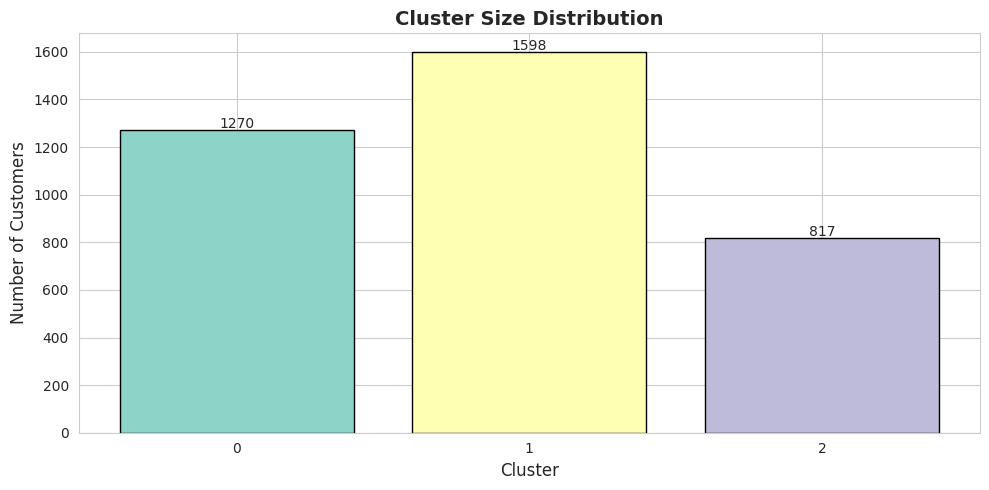

💾 Saved: results/cluster_distribution.png


In [69]:
plt.figure(figsize=(10, 5))

# Count plot
cluster_counts = labels.value_counts().sort_index()
colors = plt.cm.Set3(range(len(cluster_counts)))

plt.bar(cluster_counts.index, cluster_counts.values, color=colors, edgecolor='black')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Cluster Size Distribution', fontsize=14, fontweight='bold')
plt.xticks(cluster_counts.index)

# Add value labels
for i, v in enumerate(cluster_counts.values):
    plt.text(cluster_counts.index[i], v + 10, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('results/cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Saved: results/cluster_distribution.png")

## 4. PCA Visualization (2D)

PCA explained variance: [0.17998221 0.07915804]
Total variance explained: 25.91%


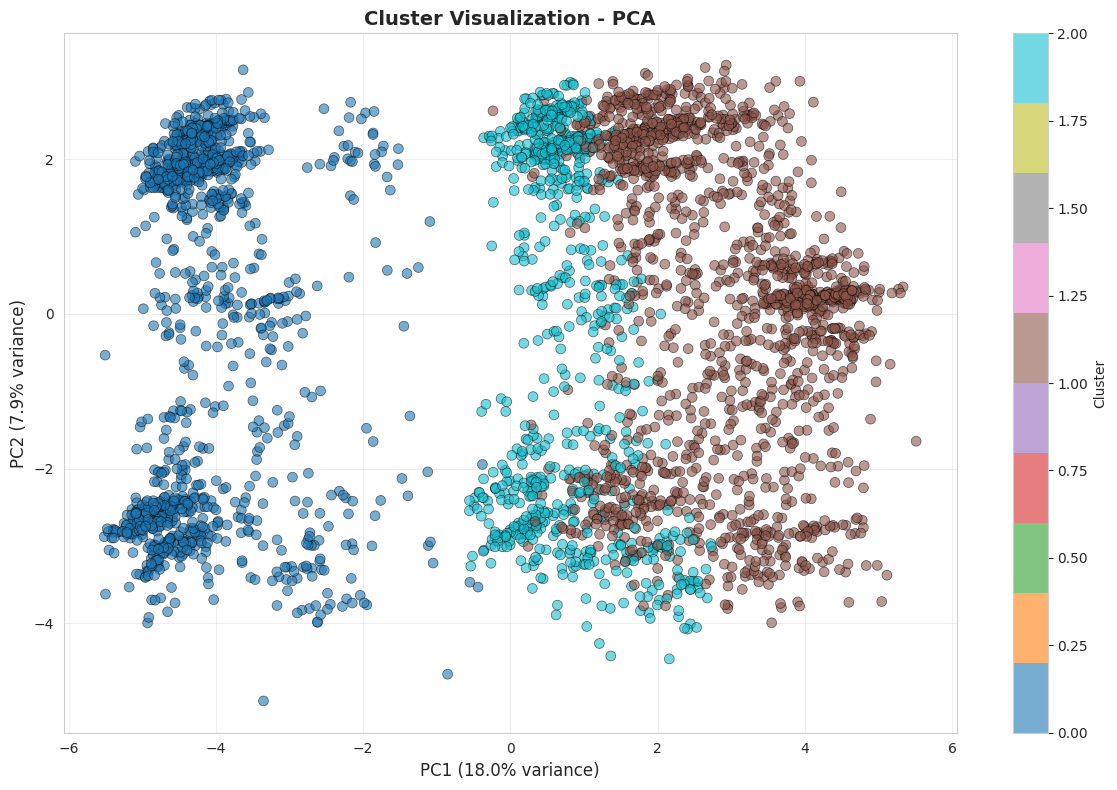

💾 Saved: results/cluster_pca.png


In [70]:
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10',
                     alpha=0.6, edgecolors='black', linewidth=0.5, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Cluster Visualization - PCA', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/cluster_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Saved: results/cluster_pca.png")

## 5. t-SNE Visualization (2D)

⚠️ **t-SNE chạy chậm với data lớn (~1-2 phút)**

Running t-SNE (this may take 1-2 minutes)...


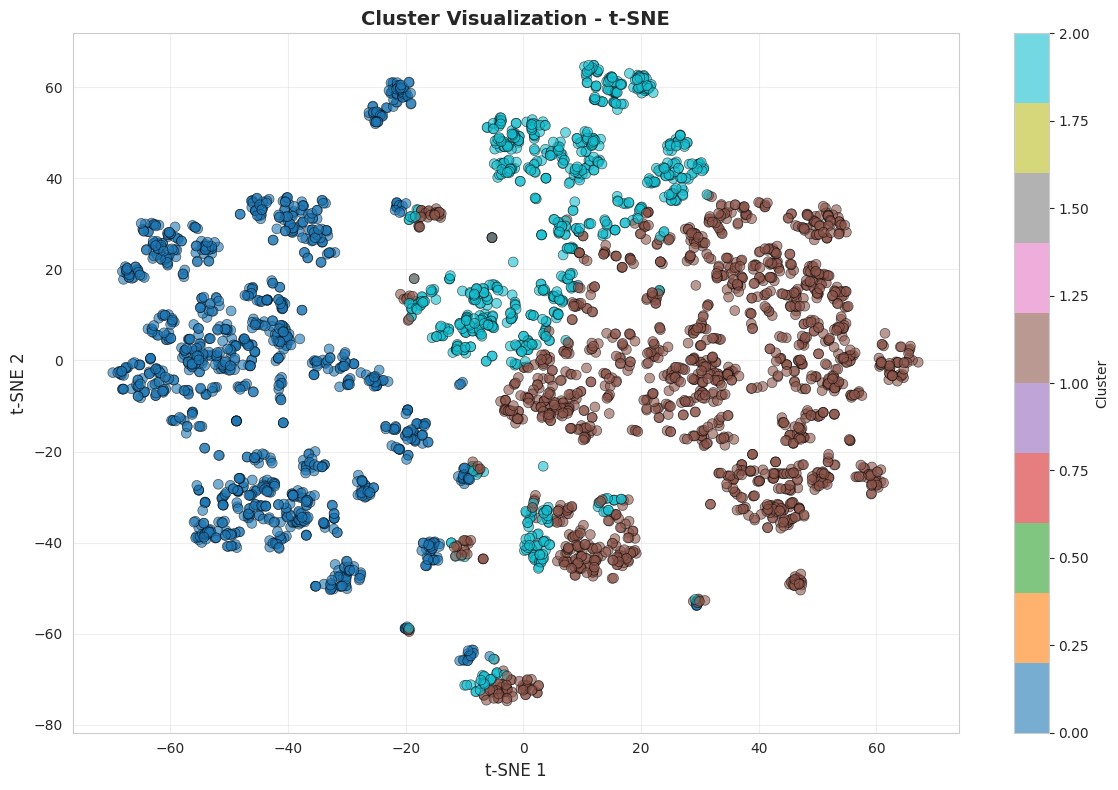

💾 Saved: results/cluster_tsne.png


In [71]:
# t-SNE to 2D
print("Running t-SNE (this may take 1-2 minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10',
                     alpha=0.6, edgecolors='black', linewidth=0.5, s=50)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title('Cluster Visualization - t-SNE', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/cluster_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Saved: results/cluster_tsne.png")

## 6. Cluster Profiling

Phân tích đặc điểm trung bình của từng cluster

Top 10 features with highest variance:
['Age_Group_2', 'Segmentation', 'Brand_Loyalty', 'Trial_flag', 'Funnel_Depth', 'Age', 'Spending', 'NPS_P3M', 'P3M_flag', 'Visit']


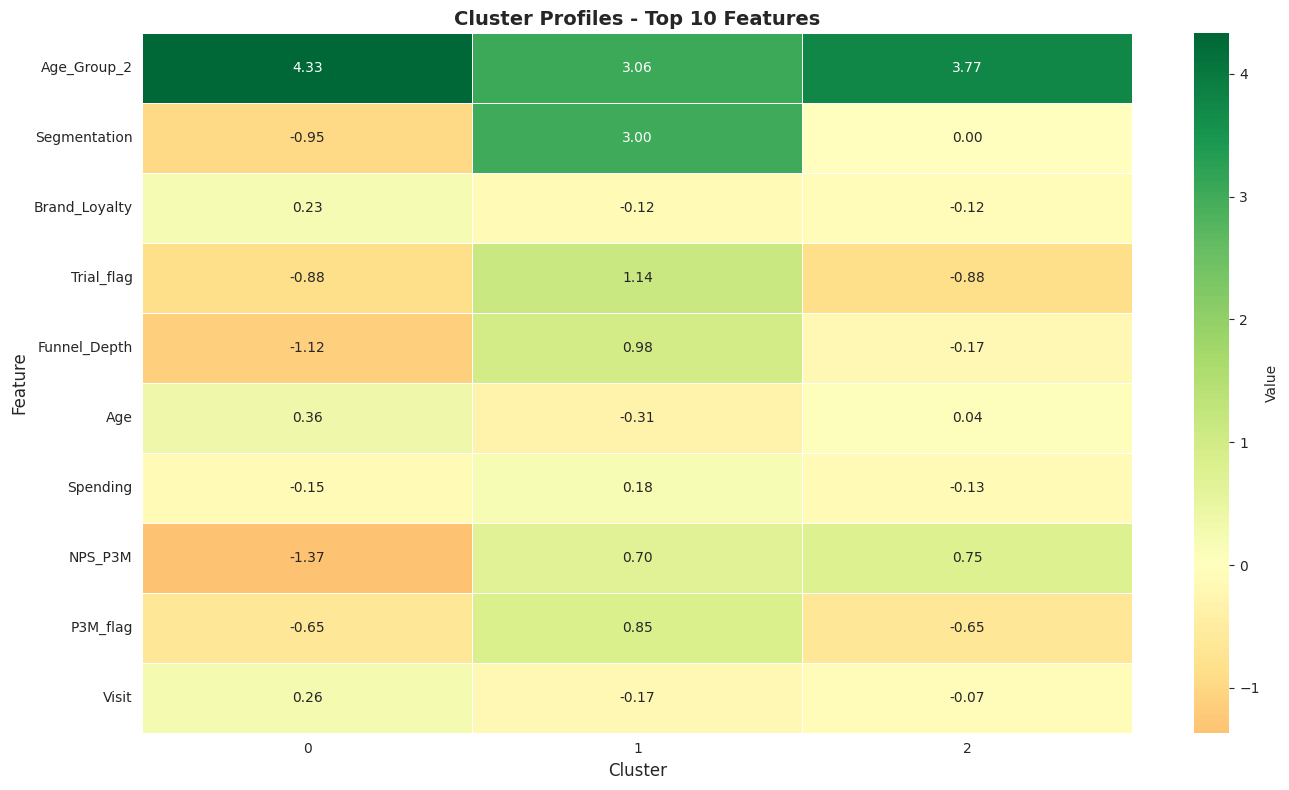

💾 Saved: results/cluster_profiles.png


In [72]:
# Tính mean của từng cluster
cluster_profiles = df.groupby('cluster').mean()

# Lấy 10 features quan trọng nhất (có variance cao)
feature_variance = X.var().sort_values(ascending=False)
top_features = feature_variance.head(10).index.tolist()

print("Top 10 features with highest variance:")
print(top_features)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_profiles[top_features].T, annot=True, fmt='.2f',
            cmap='RdYlGn', center=0, linewidths=0.5, cbar_kws={'label': 'Value'})
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Cluster Profiles - Top 10 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Saved: results/cluster_profiles.png")

## 7. Export Cluster Summary

In [74]:
# Summary statistics
summary = pd.DataFrame({
    'Cluster': sorted(labels.unique()),
    'Count': labels.value_counts().sort_index().values,
    'Percentage': (labels.value_counts().sort_index().values / len(labels) * 100).round(2)
})

# Add mean silhouette per cluster
cluster_silhouette = []
for cluster in sorted(labels.unique()):
    cluster_sil = sample_silhouette_values[labels == cluster].mean()
    cluster_silhouette.append(cluster_sil)

summary['Avg_Silhouette'] = cluster_silhouette

print("\n" + "="*60)
print("CLUSTER SUMMARY")
print("="*60)
print(summary.to_string(index=False))


CLUSTER SUMMARY
 Cluster  Count  Percentage  Avg_Silhouette
       0   1270       34.46        0.197906
       1   1598       43.36        0.064743
       2    817       22.17        0.168597

💾 Saved: results/cluster_summary.csv


In [76]:
try:
    df_raw = pd.read_csv("data/processed/merged_full.csv")
    df_clustered = df.copy()
    df_clustered['cluster'] = labels

    # Merge để có cả label và data gốc
    if len(df_raw) == len(df_clustered):
        df_full = pd.concat([df_raw.reset_index(drop=True),
                             df_clustered[['cluster']].reset_index(drop=True)], axis=1)

        print("="*80)
        print("CLUSTER PROFILING - PHÂN TÍCH ĐẶC ĐIỂM TỪNG CỤM")
        print("="*80)

        for cluster_id in sorted(labels.unique()):
            if cluster_id == -1:
                print(f"\n{'='*80}")
                print(f"CLUSTER {cluster_id} (NOISE - Điểm nhiễu)")
                print(f"{'='*80}")
            else:
                print(f"\n{'='*80}")
                print(f"CLUSTER {cluster_id}")
                print(f"{'='*80}")

            cluster_data = df_full[df_full['cluster'] == cluster_id]
            print(f"📊 Size: {len(cluster_data)} customers ({len(cluster_data)/len(df_full)*100:.1f}%)")

            # Statistics cho numeric columns
            numeric_cols = df_raw.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                print(f"\n📈 Numeric Features (Mean):")
                for col in numeric_cols[:10]:  # Top 10 features
                    cluster_mean = cluster_data[col].mean()
                    overall_mean = df_raw[col].mean()
                    diff_pct = ((cluster_mean - overall_mean) / overall_mean * 100) if overall_mean != 0 else 0

                    symbol = "🔺" if diff_pct > 10 else "🔻" if diff_pct < -10 else "➡️"
                    print(f"  {symbol} {col:30s}: {cluster_mean:8.2f} (overall: {overall_mean:8.2f}, {diff_pct:+6.1f}%)")

            # Statistics cho categorical columns
            categorical_cols = df_raw.select_dtypes(include=['object']).columns
            if len(categorical_cols) > 0:
                print(f"\n📊 Categorical Features (Mode):")
                for col in categorical_cols[:5]:  # Top 5 categorical
                    if cluster_data[col].notna().sum() > 0:
                        mode_val = cluster_data[col].mode()[0] if len(cluster_data[col].mode()) > 0 else 'N/A'
                        mode_pct = (cluster_data[col] == mode_val).sum() / len(cluster_data) * 100
                        print(f"  • {col:30s}: {mode_val} ({mode_pct:.1f}%)")

        # Save detailed profiling
        profiling_results = []
        for cluster_id in sorted(labels.unique()):
            cluster_data = df_full[df_full['cluster'] == cluster_id]
            profile = {'cluster': cluster_id, 'size': len(cluster_data)}

            # Add numeric means
            for col in numeric_cols:
                profile[f'{col}_mean'] = cluster_data[col].mean()

            # Add categorical modes
            for col in categorical_cols:
                if cluster_data[col].notna().sum() > 0:
                    profile[f'{col}_mode'] = cluster_data[col].mode()[0] if len(cluster_data[col].mode()) > 0 else 'N/A'

            profiling_results.append(profile)

        df_profiling = pd.DataFrame(profiling_results)
        df_profiling.to_csv('results/cluster_profiling.csv', index=False)
        print("\n💾 Saved detailed profiling: results/cluster_profiling.csv")

    else:
        print("⚠️ Raw data và clustered data không match về số lượng rows!")

except FileNotFoundError:
    print("⚠️ Không tìm thấy file data/raw/highlands_customer_data.csv")
    print("   Phân tích đặc điểm dựa trên encoded features:")

    # Fallback: Analyze encoded features
    df_with_labels = X.copy()
    df_with_labels['cluster'] = labels

    print("\n" + "="*80)
    print("CLUSTER PROFILING - ENCODED FEATURES")
    print("="*80)

    for cluster_id in sorted(labels.unique()):
        print(f"\nCluster {cluster_id}:")
        cluster_data = df_with_labels[df_with_labels['cluster'] == cluster_id]
        print(f"  Size: {len(cluster_data)} ({len(cluster_data)/len(df_with_labels)*100:.1f}%)")

        # Top 5 features với giá trị cao nhất so với overall mean
        feature_diffs = {}
        for col in X.columns:
            cluster_mean = cluster_data[col].mean()
            overall_mean = X[col].mean()
            diff = cluster_mean - overall_mean
            feature_diffs[col] = diff

        print("\n  Top 5 distinctive features (vs overall):")
        top_features = sorted(feature_diffs.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
        for feat, diff in top_features:
            symbol = "🔺" if diff > 0 else "🔻"
            print(f"    {symbol} {feat}: {diff:+.3f}")

CLUSTER PROFILING - PHÂN TÍCH ĐẶC ĐIỂM TỪNG CỤM

CLUSTER 0
📊 Size: 1270 customers (34.5%)

📈 Numeric Features (Mean):
  ➡️ ID                            : 123592.51 (overall: 125021.22,   -1.1%)
  ➡️ Group_size                    :     3.00 (overall:     3.19,   -5.9%)
  🔺 Age                           :    40.36 (overall:    36.36,  +11.0%)
  ➡️ Year                          :  2017.00 (overall:  2017.00,   +0.0%)
  🔻 NPS_P3M                       :    -1.00 (overall:     5.44, -118.4%)
  🔺 Visit                         :    12.28 (overall:     9.07,  +35.3%)
  🔻 Spending                      :   166.72 (overall:   191.03,  -12.7%)
  🔻 PPA                           :    18.35 (overall:    27.88,  -34.2%)

📊 Categorical Features (Mode):
  • City                          : Cần Thơ (36.2%)
  • TOM                           : Independent Cafe (56.0%)
  • BUMO                          : Independent Cafe (57.8%)
  • BUMO_Previous                 : Don't have any brands (73.3%)
  • MostFavou

**Cluster 0 – Nhóm Trung Niên Ghé Nhiều Nhưng Chi Ít**

- Độ tuổi cao nhất (≈40 tuổi).
- Tần suất ghé quán cao nhất trong 3 nhóm.
- Chi tiêu trên mỗi lần (PPA) thấp và tổng chi tiêu thấp.
- NPS thấp → mức độ hài lòng kém.
- Ưa chuộng quán địa phương (Independent Cafe) hơn là Highlands.
- Tập trung nhiều ở Cần Thơ.

**Cluster 1 – Nhóm Trẻ Chi Tiêu Cao, Hài Lòng Cao**

- Độ tuổi thấp nhất (≈33 tuổi).
- Chi tiêu mỗi lần và tổng chi tiêu cao nhất.
- NPS rất cao → hài lòng mạnh với thương hiệu.
- Tần suất ghé thấp hơn nhóm 0.
- Có xu hướng chọn Highlands làm thương hiệu yêu thích.
- Tập trung nhiều ở Hà Nội.

**Cluster 2 – Nhóm Hài Lòng Cao Nhưng Chi Tiêu Thấp**

- Độ tuổi trung bình, gần với toàn bộ mẫu.
- NPS cao nhất trong 3 nhóm.
- Chi tiêu thấp (tổng chi tiêu và PPA đều thấp).
- Tần suất ghé ở mức trung bình – thấp.
- Chủ yếu thích Independent Cafe hơn Highlands.
- Tập trung nhiều tại TP.HCM.

## 8. All Plots in One Figure

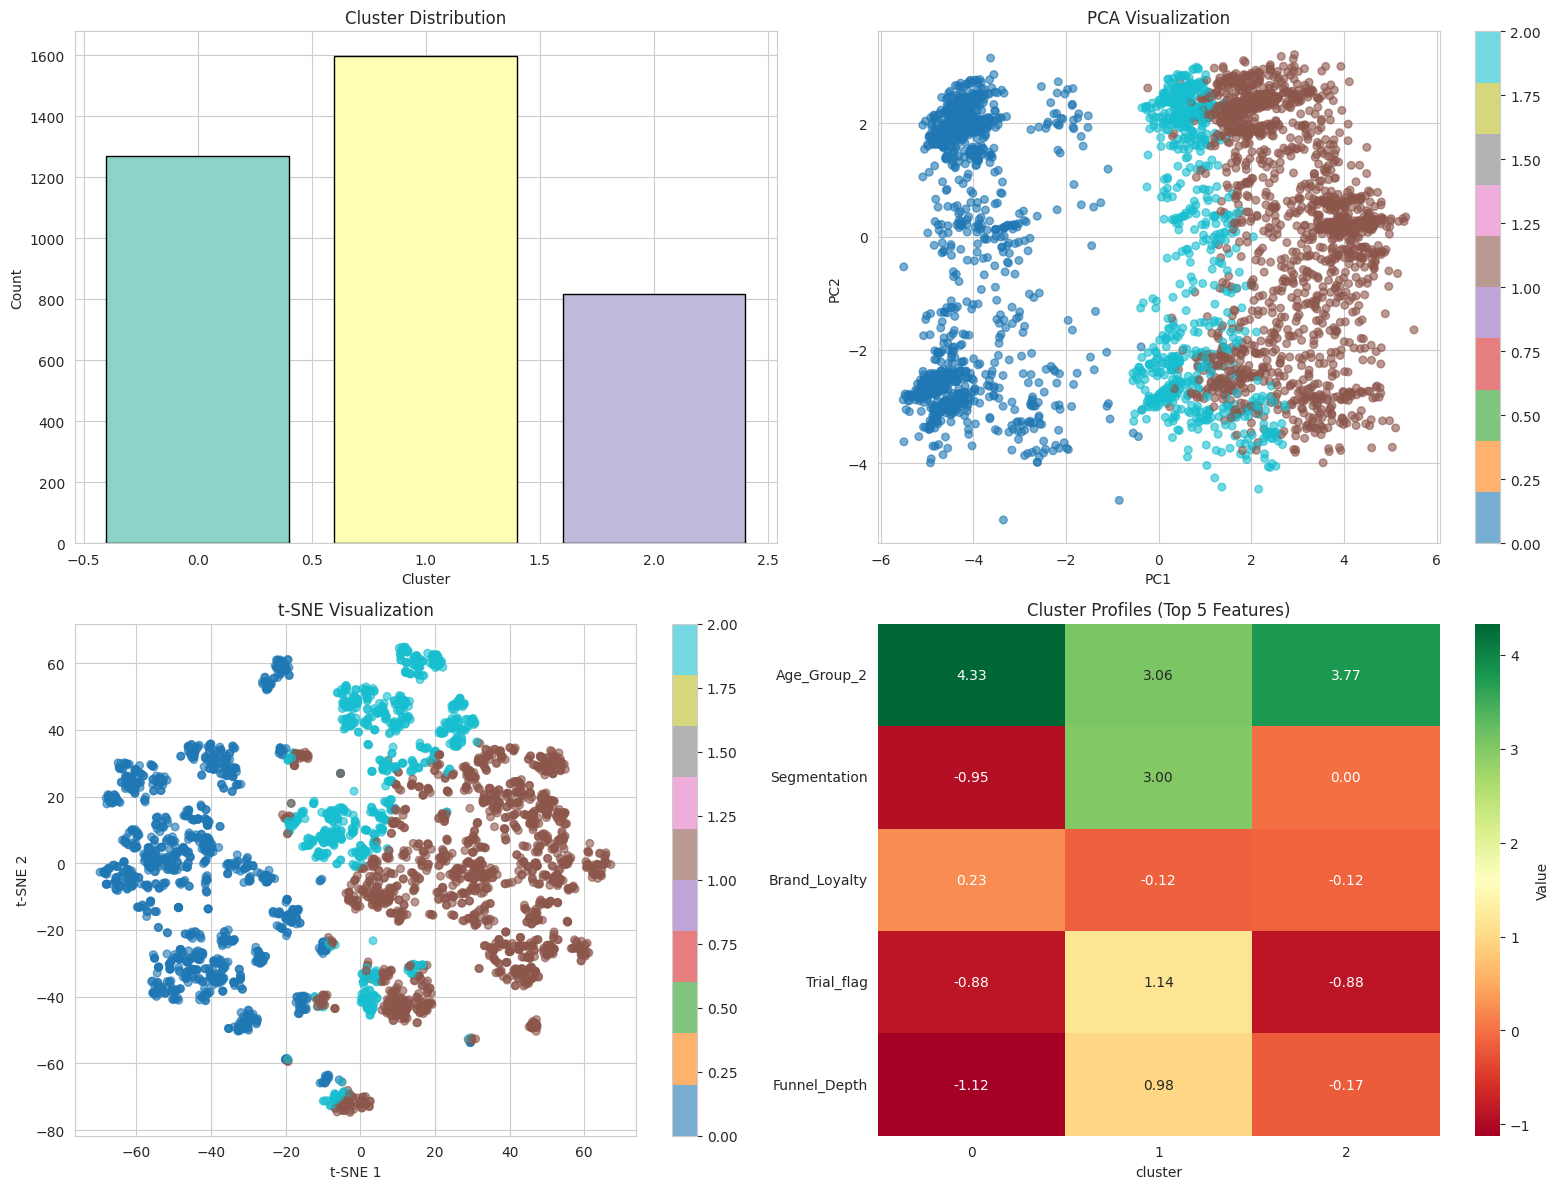

💾 Saved: results/all_visualizations.png


In [75]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution
axes[0, 0].bar(cluster_counts.index, cluster_counts.values,
               color=plt.cm.Set3(range(len(cluster_counts))), edgecolor='black')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Cluster Distribution')

# 2. PCA
scatter1 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.6, s=30)
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
axes[0, 1].set_title('PCA Visualization')
plt.colorbar(scatter1, ax=axes[0, 1])

# 3. t-SNE
scatter2 = axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6, s=30)
axes[1, 0].set_xlabel('t-SNE 1')
axes[1, 0].set_ylabel('t-SNE 2')
axes[1, 0].set_title('t-SNE Visualization')
plt.colorbar(scatter2, ax=axes[1, 0])

# 4. Cluster profiles (top 5 features)
sns.heatmap(cluster_profiles[top_features[:5]].T, annot=True, fmt='.2f',
            cmap='RdYlGn', ax=axes[1, 1], cbar_kws={'label': 'Value'})
axes[1, 1].set_title('Cluster Profiles (Top 5 Features)')

plt.tight_layout()
plt.savefig('results/all_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Saved: results/all_visualizations.png")